# State Farm Distracted Driver Detection

This is a fastai lesson 1 homework: submit solution to Kaggle image recognition competition, other than "Dogs vs Cats".
State Farm Distracted Driver Detection https://www.kaggle.com/c/state-farm-distracted-driver-detection/data
is listed amongs the simplest problems to submit, so I am trying it.


Plan:
    1. Prepare environment
    2. Download competition data
    3. Rearrange the data
    4. Train model
    5. Verify model
    6. Generate predictions
    7. Submit to Kaggle

    

## Prepare environment


In [1]:
#Verify we are in the homework directory
%pwd

u'/home/tollek/workspace/personal/fastai/fastai-tollek/homework'

In [2]:
import os,sys
WORKING_DIR = os.getcwd()
DATA_DIR = WORKING_DIR + "/../data/state-farm-distracted-driver-detection"

In [3]:
lib_path = os.path.abspath('../fastai-course/deeplearning1/nbs/')
print lib_path
sys.path.append(lib_path)

#import modules
from utils import *
from vgg16 import Vgg16

import numpy as np
np.set_printoptions(precision=4, linewidth=100)

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

/home/tollek/workspace/personal/fastai/fastai-tollek/fastai-course/deeplearning1/nbs


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 755M (CNMeM is disabled, cuDNN 5103)
Using Theano backend.


## Download competition data

In [13]:
%cd $DATA_DIR

/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection


In [14]:
! kg download -c state-farm-distracted-driver-detection

downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/sample_submission.csv.zip

sample_submission.csv.zip already downloaded !
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/imgs.zip

imgs.zip already downloaded !
downloading https://www.kaggle.com/c/state-farm-distracted-driver-detection/download/driver_imgs_list.csv.zip

driver_imgs_list.csv.zip already downloaded !


In [16]:
! unzip -u -q driver_imgs_list.csv.zip
! unzip -u -q imgs.zip

## Rearrange the data

First, we need to create a validation set. We should pick driver/drivers and copy files belonging to this driver only.

In [22]:
# count total numer of files in train directory
! find train/ -type f | wc -l

22424


In [20]:
# count number of files per driver
! awk -F, '{a[$1]++;}END{for (i in a)print i, a[i];}' driver_imgs_list.csv

subject 1
p002 725
p012 823
p021 1237
p014 876
p022 1233
p015 875
p016 1078
p024 1226
p026 1196
p041 605
p042 591
p035 848
p050 790
p051 920
p052 740
p045 724
p039 651
p061 809
p047 835
p056 794
p049 1011
p064 820
p072 346
p066 1034
p081 823
p075 814


In [25]:
# or number of classes per driver
! awk -F, '{a[$1 " " $2]++;}END{for (i in a)print i, a[i];}' driver_imgs_list.csv | grep p066

p066 c0 129
p066 c1 100
p066 c2 106
p066 c3 101
p066 c4 102
p066 c5 101
p066 c6 105
p066 c7 86
p066 c8 114
p066 c9 90


## Create validation dir

In [50]:
# create validation directory and move some driver data there
%mkdir valid
for c in xrange(0,10):
    class_dir = 'valid/c{:d}'.format(c)
    %mkdir $class_dir

In [51]:
drivers = ["p022", "p066"]

In [52]:
from shutil import move

driver_imgs = open('driver_imgs_list.csv').read().splitlines()[1:]
counter = 0
for f in driver_imgs:
    driver, classname, img = f.split(',')
    if driver in drivers:
        src = 'train/{0}/{1}'.format(classname, img)
        dst = 'valid/{0}/{1}'.format(classname, img)
        move(src, dst)

### Create sample dir

In [61]:
%cd $DATA_DIR/train
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid


/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection/train


In [62]:
for d in glob('c?'):
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [63]:
from shutil import copyfile

In [64]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1500): copyfile(shuf[i], '../sample/train/' + shuf[i])

In [65]:
%cd ../valid

/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection/valid


In [66]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1000): copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [71]:
%cd $DATA_DIR
%mkdir results
%mkdir sample/results

/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection
mkdir: cannot create directory ‘results’: File exists
mkdir: cannot create directory ‘sample/results’: File exists


## Train model

In [5]:
%cd $DATA_DIR

path = DATA_DIR
#path = DATA_DIR + '/sample'
test_path = DATA_DIR + '/test/' 
results_path=DATA_DIR + '/results/'
train_path=path + '/train/'
valid_path=path + '/valid/'

%mkdir $results_path

/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection
mkdir: cannot create directory ‘/home/tollek/workspace/personal/fastai/fastai-tollek/homework/../data/state-farm-distracted-driver-detection/results/’: File exists


In [48]:
# (optionally) garbage collection of the current vgg object/model
vgg = None
import gc
for i in range(3): gc.collect()

In [49]:
#import Vgg16 helper class
vgg = Vgg16()

In [50]:
batch_size = 8
epochs = 4

In [51]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)

vgg.model.optimizer.lr = 0.001

Found 20157 images belonging to 10 classes.
Found 2267 images belonging to 10 classes.


In [ ]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % epochs

Running epoch: 0
Epoch 1/1
20157/20157 [==============================] - 3780s - loss: 1.9714 - acc: 0.5314 - val_loss: 1.8465 - val_acc: 0.4460
Running epoch: 1
Epoch 1/1
20149/20157 [============================>.] - ETA: 1s - loss: 1.6736 - acc: 0.6491

## Verify model

Plan:
    - confusion matrix
    - for each class:
        - rate of correct samples
        - TP with biggest confidence
        - FN with biggest confidence of false class
        - FP with biggest confidence of false class
        ###- incorrect samples - class with most occurences
    - samples with lowest max confidence (winner with low confidence)
    - samples with tight results (runner up close to the winner)
    

In [136]:
test_batches, predictions = vgg.test(valid_path)
filenames = val_batches.filenames
expected_labels = val_batches.classes

Found 2267 images belonging to 10 classes.


In [137]:
our_predictions = predictions
our_labels = np.argmax(our_predictions, axis=1)
classes = sorted([x for x in val_batches.class_indices.keys()])


In [265]:
cnames = [
    'c0: normal driving',
    'c1: texting - right',
    'c2: phone - right',
    'c3: texting - left',
    'c4: phone - left',
    'c5: radio',
    'c6: drinking',
    'c7: reaching behind',
    'c8: hair and makeup',
    'c9: talk passenger'
]

In [193]:
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
    
n_view = 4

### Show confusion matrix

[[244   0   0   3   5   0   0   4   2   0]
 [ 85  22  47  17  10   2  22   5  19   0]
 [  6   0 186   1   8   0   0   0  33   0]
 [ 23   0   0 196  11   0   0   0   0   0]
 [ 26   0  13  93  98   0   0   0   2   0]
 [ 62   6   0  10   0 117   0  33   3   0]
 [ 16   6  71   4  42   0  14  46  37   0]
 [  4   0   8   1   1   1   2 111  56   0]
 [ 15   5  30   1  34   0   3  26  98   0]
 [136   0   2  14   2   0   0  18   1  48]]


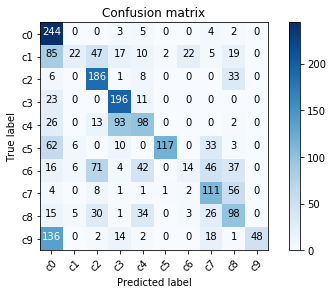

In [166]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels, our_labels)

plot_confusion_matrix(cm, classes, normalize=False)

### Analyze classes

In [279]:
def analyze_cls(c):
    # how many elements were predicted as
    print '---------------------------------------------------------------'
    print cnames[c]
    total = cm[c,:].sum()
    tp = cm[c,c]
    labeled = cm[:,c].sum()
    print 'total samples: {:d} ({:.2f})'.format(total, 1.0*tp/total)
    print '           TP: {:d}'.format(tp)
    print '           FN: {:d}'.format(total - tp)
    print '           FP: {:d}'.format(labeled - tp)
    
    # correct samples with biggest confidence
    print
    print 'TP with biggest confidence'
    correct = np.where((expected_labels == our_labels) & (expected_labels == c))[0]
    correct_p = predictions[correct,c]
    correct_p_idx = np.argsort(correct_p)[::-1]
    most_correct_idx = correct[correct_p_idx]
    plots_idx(most_correct_idx[:n_view], correct_p[correct_p_idx[:n_view]])
    plt.show()
    
    print 
    print 'FN with biggest confidence of false class'
    incorrect = np.where((expected_labels == c) & (our_labels != expected_labels))[0]
    true_class_p = predictions[incorrect,c]
    false_class_p = predictions[incorrect, our_labels[incorrect]]
    false_class_p_idx = np.argsort(false_class_p)[::-1]
    most_confident_false_idx = incorrect[false_class_p_idx]
    fmt = 'exp c{:d} - {:.4f}\n({:s})\ngot: c{:d} - {:.4f}\n({:s})\n'
    titles = [fmt.format(c, predictions[sample,c], cnames[c],
                         our_labels[sample], predictions[sample,our_labels[sample]], cnames[our_labels[sample]])
              for sample in most_confident_false_idx[:n_view]]
    plots_idx(most_confident_false_idx[:n_view], titles)
    plt.show()
    
    print 
    print 'FP with biggest confidence of false class'
    fp = np.where((our_labels == c) & (our_labels != expected_labels))[0]
    if fp:
        true_class_p = predictions[fp, expected_labels[fp]]
        false_class_p = predictions[fp, c]
        false_class_p_idx = np.argsort(false_class_p)[::-1]
        most_confident_fp_idx = fp[false_class_p_idx]
    
        fmt = 'exp c{:d} - {:.4f}\n({:s})\ngot: c{:d} - {:.4f}\n({:s})\n'
        titles = [fmt.format(expected_labels[sample], predictions[sample,expected_labels[sample]], cnames[expected_labels[sample]],
                             our_labels[sample], predictions[sample,our_labels[sample]], cnames[our_labels[sample]])
                  for sample in most_confident_fp_idx[:n_view]]
        plots_idx(most_confident_fp_idx[:n_view], titles)
        plt.show()    
    

---------------------------------------------------------------
c0: normal driving
total samples: 258 (0.95)
           TP: 244
           FN: 14
           FP: 373

TP with biggest confidence


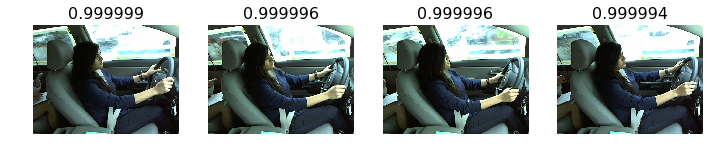


FN with biggest confidence of false class


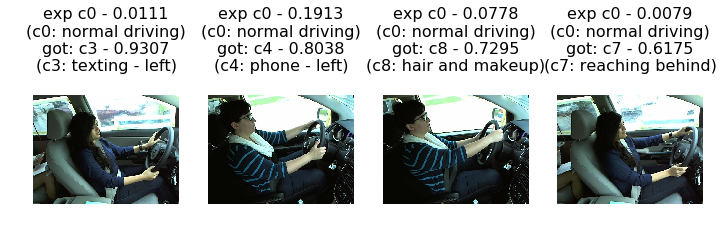


FP with biggest confidence of false class


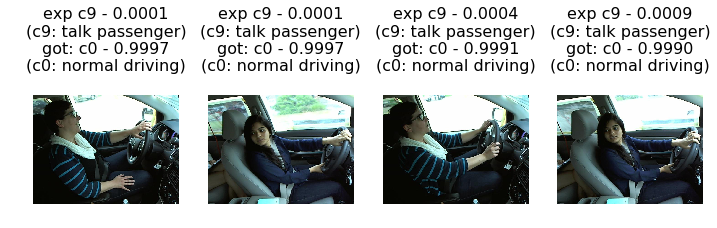

In [268]:
analyze_cls(0)

---------------------------------------------------------------
c1: texting - right
total samples: 229 (0.10)
           TP: 22
           FN: 207
           FP: 17

TP with biggest confidence


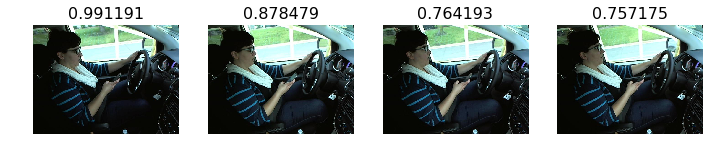


FN with biggest confidence of false class


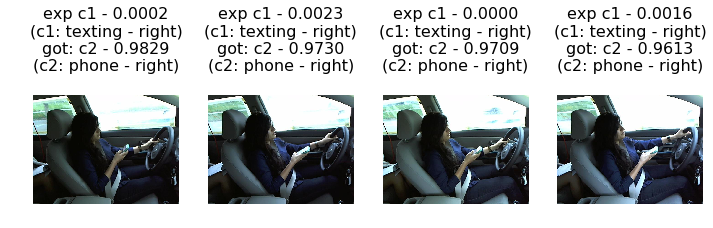


FP with biggest confidence of false class


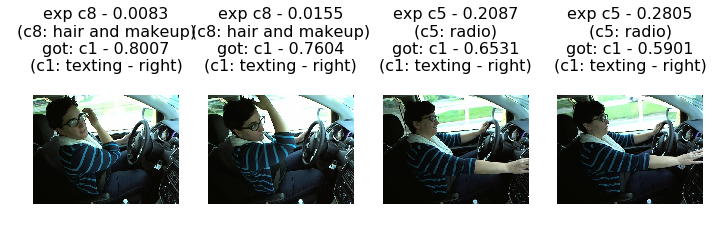

In [269]:
analyze_cls(1)

---------------------------------------------------------------
c2: phone - right
total samples: 234 (0.79)
           TP: 186
           FN: 48
           FP: 171

TP with biggest confidence


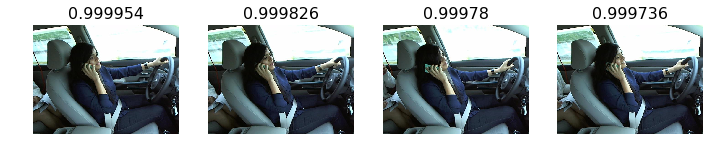


FN with biggest confidence of false class


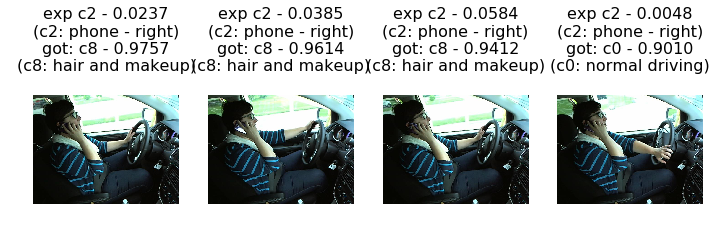


FP with biggest confidence of false class


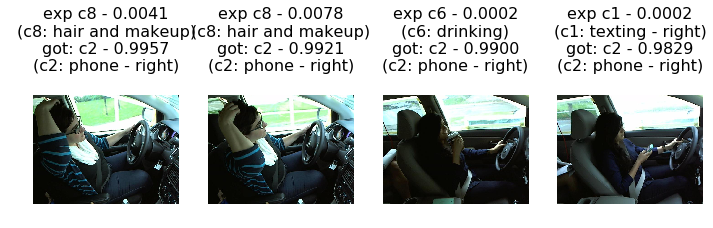

In [270]:
analyze_cls(2)

---------------------------------------------------------------
c3: texting - left
total samples: 230 (0.85)
           TP: 196
           FN: 34
           FP: 144

TP with biggest confidence


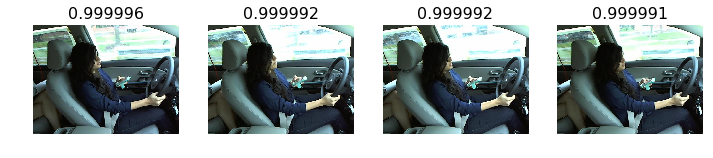


FN with biggest confidence of false class


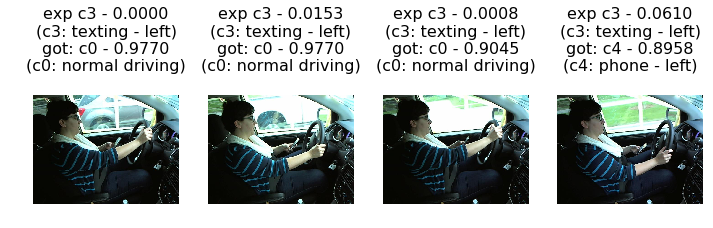


FP with biggest confidence of false class


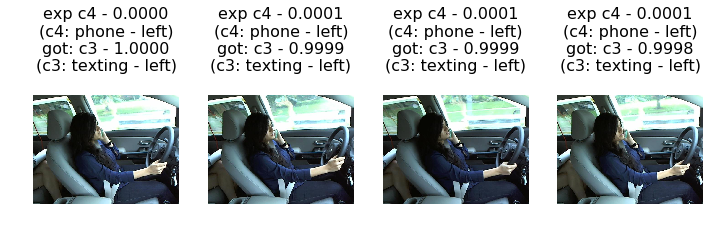

In [271]:
analyze_cls(3)

---------------------------------------------------------------
c4: phone - left
total samples: 232 (0.42)
           TP: 98
           FN: 134
           FP: 113

TP with biggest confidence


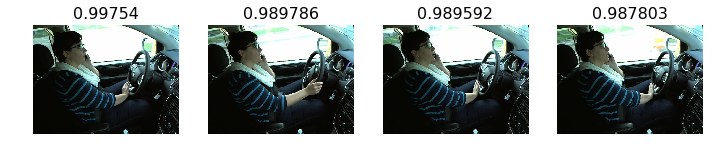


FN with biggest confidence of false class


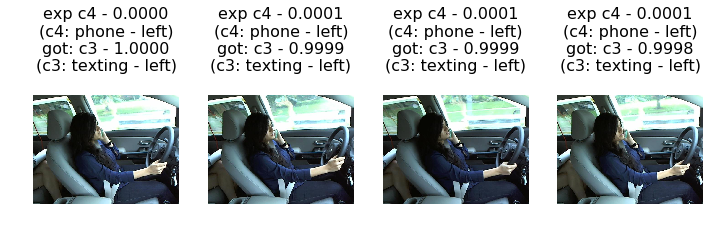


FP with biggest confidence of false class


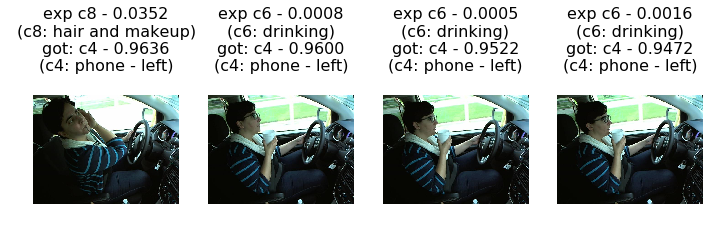

In [272]:
analyze_cls(4)

---------------------------------------------------------------
c5: radio
total samples: 231 (0.51)
           TP: 117
           FN: 114
           FP: 3

TP with biggest confidence


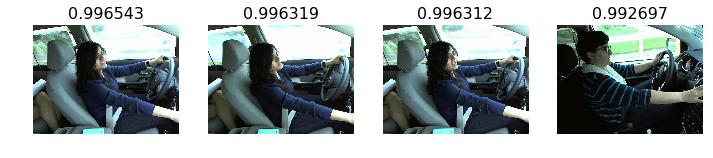


FN with biggest confidence of false class


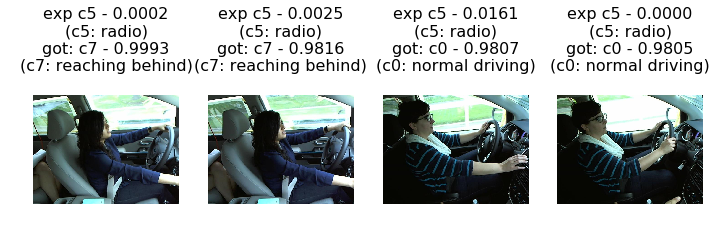


FP with biggest confidence of false class


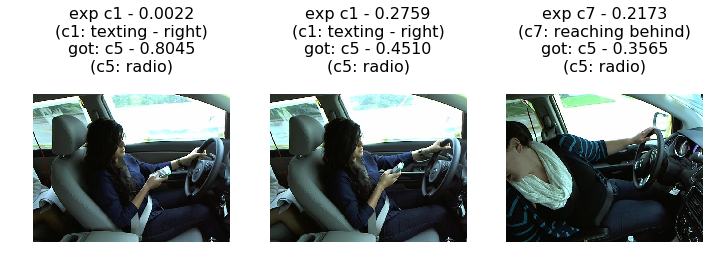

In [273]:
analyze_cls(5)

---------------------------------------------------------------
c6: drinking
total samples: 236 (0.06)
           TP: 14
           FN: 222
           FP: 27

TP with biggest confidence


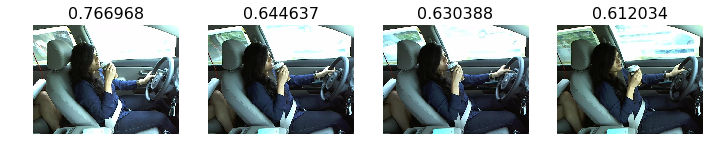


FN with biggest confidence of false class


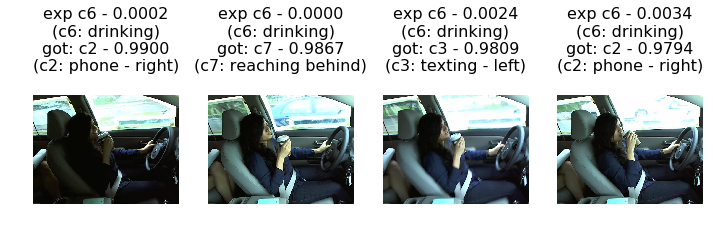


FP with biggest confidence of false class


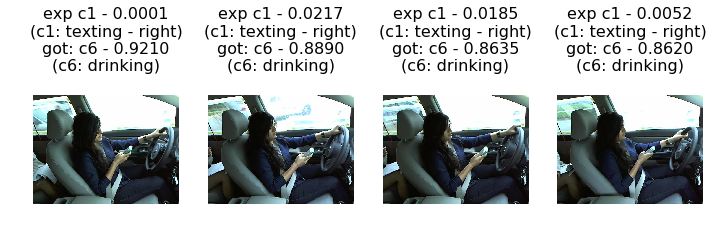

In [274]:
analyze_cls(6)

---------------------------------------------------------------
c7: reaching behind
total samples: 184 (0.60)
           TP: 111
           FN: 73
           FP: 132

TP with biggest confidence


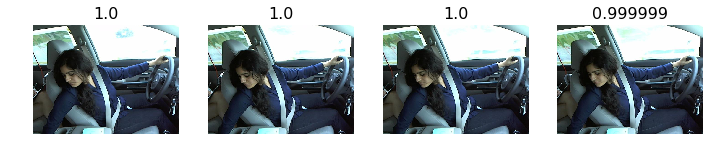


FN with biggest confidence of false class


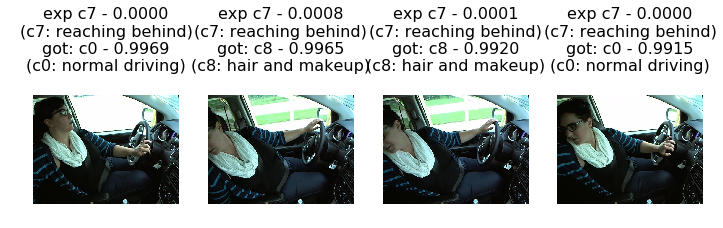


FP with biggest confidence of false class


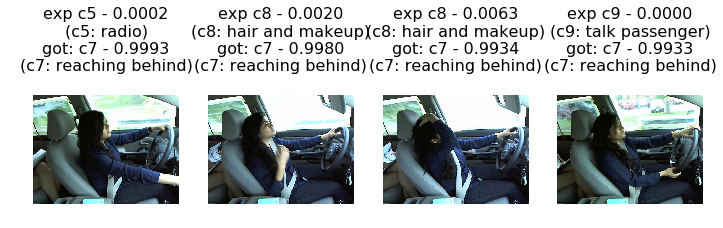

In [275]:
analyze_cls(7)

---------------------------------------------------------------
c8: hair and makeup
total samples: 212 (0.46)
           TP: 98
           FN: 114
           FP: 153

TP with biggest confidence


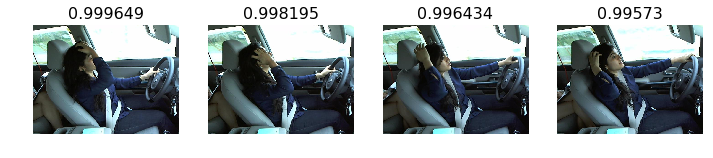


FN with biggest confidence of false class


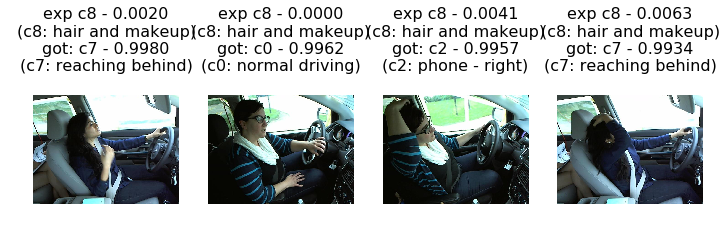


FP with biggest confidence of false class


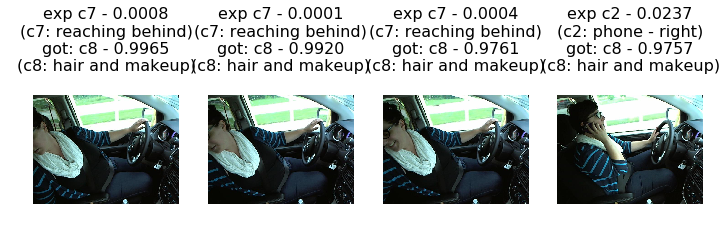

In [276]:
analyze_cls(8)

---------------------------------------------------------------
c9: talk passenger
total samples: 221 (0.22)
           TP: 48
           FN: 173
           FP: 0

TP with biggest confidence


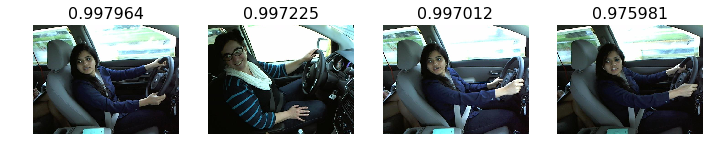


FN with biggest confidence of false class


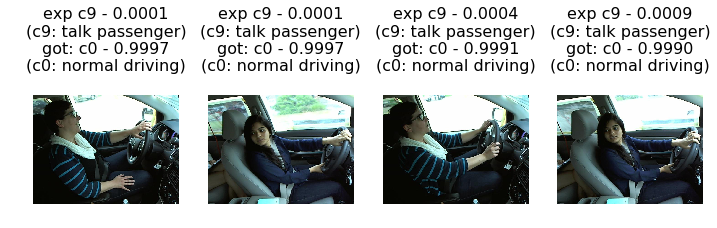


FP with biggest confidence of false class


In [280]:
analyze_cls(9)

### Validation conclusions
1. Clearly the model is not trained properly. There are still 'easy' samples
   that model should catch.   
   Is it problems with model structure? Learning parameters (e.g. regularization)? Not enough data?
2. Distinguish between talking vs texting is hard
3. Distinguish between using phone (talking/texting) vs drinking is hard
4. Turning right is often mislabeled as talking to passenger / reaching behind.
   How to teach the model here?
5. Talking to passenger vs normal driving looks super hard.
   From manual browsing of the samples, I often have problem to distinguish those two.


## Generate predictions

In [9]:
# (optionally) garbage collection of the current vgg object/model
vgg = None
import gc
for i in range(3): gc.collect()

In [10]:
batch_size = 8

vgg = Vgg16()
batches = vgg.get_batches(tbrain_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)
vgg.finetune(batches)
vgg.model.load_weights(results_path+"ft1.h5")

Found 20157 images belonging to 10 classes.
Found 2267 images belonging to 10 classes.


In [12]:
test_batches, predictions = vgg.test(test_path, batch_size=batch_size)
filenames = test_batches.filenames

save_array(results_path+'predictions', predictions)
save_array(results_path+'filenames', filenames)

Found 79726 images belonging to 1 classes.


## Submit to Kaggle

In [135]:
print len(filenames)
print filenames[:5]

79726
['unknown/img_39642.jpg', 'unknown/img_21740.jpg', 'unknown/img_31214.jpg', 'unknown/img_66391.jpg', 'unknown/img_15401.jpg']


In [131]:
# generate predictions
# NOTE: there is lots of playing with the clip_min/clip_max values: due to log_loss function used to evaluate
# solutions, it makes sense to decrease responses in situations when we're less confident about the answer.
# Also, note that the responses are rescaled (sum(responses)=1), so those are not final probabilities.
# 0.1 / 0.9 gave 1.77832 score == place 818/1440=.56th percentile

tmp = np.array(predictions)
our_labels = np.argmax(tmp, axis=1)

clip_min = 0.1
clip_max = 0.9
our_classes = np.full(tmp.shape, clip_min)
our_classes[np.arange(0, len(our_labels)), our_labels] = clip_max
print our_classes[:5]


[[ 0.1  0.1  0.9  0.1  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.9  0.1]
 [ 0.1  0.1  0.1  0.9  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.1  0.9  0.1  0.1  0.1  0.1  0.1  0.1]
 [ 0.1  0.1  0.9  0.1  0.1  0.1  0.1  0.1  0.1  0.1]]


(79726, 10)

In [132]:
# build single array with filenames (file ids) + predictions.

# TODO(pawelb): instead of ndarray, we should use dataframe?
# there are strings(filename) and floats (predictions).
subm_names = [int(x[12:x.find('.')]) for x in filenames]
subm_names = np.array(subm_names).reshape((len(filenames), 1))


x = np.array(filenames).reshape((len(filenames), 1))
csv_content = np.hstack((subm_names, our_classes))
csv_content[0]

array([  3.9642e+04,   1.0000e-01,   1.0000e-01,   9.0000e-01,   1.0000e-01,   1.0000e-01,
         1.0000e-01,   1.0000e-01,   1.0000e-01,   1.0000e-01,   1.0000e-01])

In [133]:
%cd $DATA_DIR
submission_file_name = 'submission2.csv'
fmt = 'img_%d.jpg,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f,%.5f'
header = 'img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9'
np.savetxt(submission_file_name, csv_content, fmt=fmt, header=header, comments='')

/home/tollek/workspace/personal/fastai/data/state-farm-distracted-driver-detection
